In [145]:
import sys
sys.path.append('../src')
from data_manager import *

import os
import matplotlib.pyplot as plt
import numpy as np

import cv2
from skimage.feature import hog

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

root_path = '../'

# HOG Features Building with CK+48 dataset

### Data

In [7]:
ck_data_path = os.path.join(root_path, 'data/CK+48')
ck_data_path

image_files = list(get_image_paths(ck_data_path))

images = get_images(image_files)
labels = get_labels(image_files, 'ck')

print(f"Dataset length: {len(image_files)}")
print(f"Image shape: {images[0].shape}")

  0%|          | 0/981 [00:00<?, ?it/s]

100%|██████████| 981/981 [00:06<00:00, 151.35it/s]

Dataset length: 981
Image shape: (48, 48)


### Gradients

**HOG paper**
- Simple 1-D [−1, 0, 1] masks at σ=0 work best
- Including signed gradients decreases the
performance, even when the number of bins is also doubled
to preserve the original orientation resolution.

Text(0.5, 1.0, 'Gradient direction')

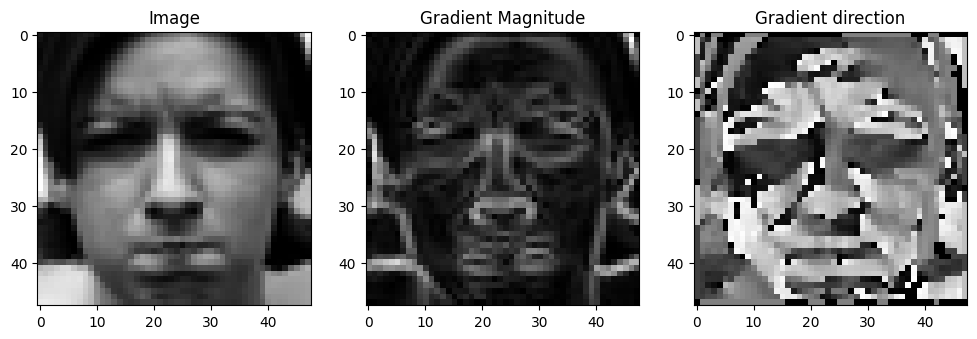

In [41]:
def compute_gradients(image):
    """
    Computes gradient magnitude and gradient direction of an image
    based on Sobel filters.

    Parameters
    ----------
    image:
        Input image of size (h, w)

    Returns
    -------
    magnitude:
        Image of size (h, w) with gradient magnitude
    direction:
        Image of size (h, w) with gradient direction
    """

    gx = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=1)

    magnitude, direction = cv2.cartToPolar(gx, gy, angleInDegrees=True)

    return magnitude, direction


image = images[0]
magnitude, direction = compute_gradients(image)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Image')

plt.subplot(1, 3, 2)
plt.imshow(magnitude, cmap='gray')
plt.title('Gradient Magnitude')

plt.subplot(1, 3, 3)
plt.imshow(direction, cmap='gray')
plt.title('Gradient direction')

In [44]:
direction = np.mod(gradient_direction, 180)
np.any(direction > 180)

False

### Histograms

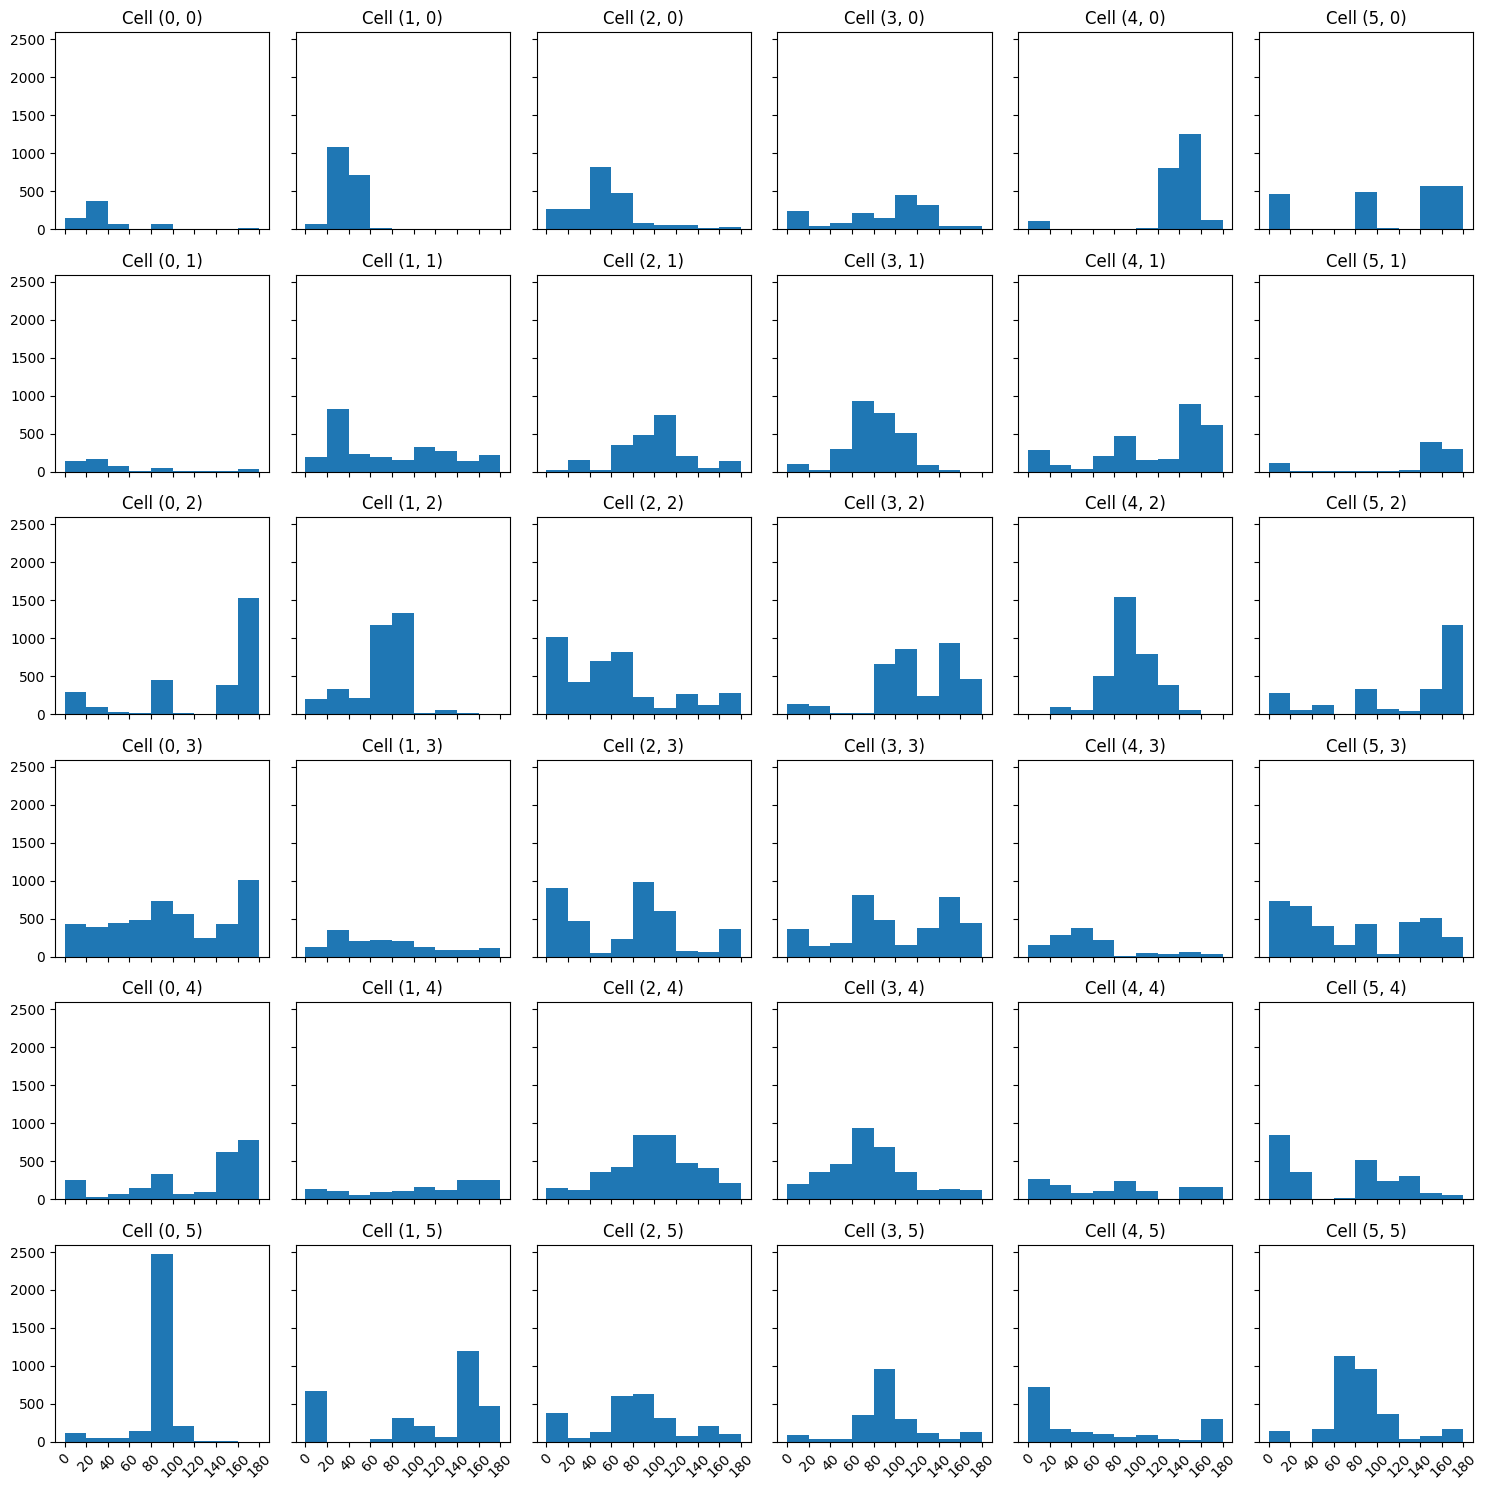

In [117]:
def compute_histograms(magnitude, direction, cell_size=(8,8), bins=9, plot=False):

    direction = np.mod(direction, 180)

    cells_x = magnitude.shape[1] // cell_size[0]
    cells_y = magnitude.shape[0] // cell_size[1]

    # print(cells_x) # 6
    # print(cells_y) # 6

    histograms = []

    for i in range(cells_y):
        for j in range(cells_x):

            cell_magnitude = magnitude[
                i * cell_size[1]: (i + 1) * cell_size[1], 
                j * cell_size[0]: (j + 1) * cell_size[0]
            ]
            cell_direction = direction[
                i * cell_size[1]: (i + 1) * cell_size[1], 
                j * cell_size[0]: (j + 1) * cell_size[0]
            ]

            histogram, _ = np.histogram(cell_direction, bins=bins, range=(0, 180), weights=cell_magnitude)
            histograms.append(histogram)

    histograms = np.array(histograms)

    if plot:

        fig, axs = plt.subplots(cells_x,  cells_y, figsize=(15, 15), sharex=True, sharey=True)

        for i in range(cells_y):
            for j in range(cells_x):
                axs[i, j].bar(np.arange(9)*20, histograms[i*cells_y+j], width=20, align='edge')
                axs[i, j].set_title(f'Cell ({j}, {i})')
                axs[i, j].tick_params(axis='x', rotation=45)
        
        plt.xticks(np.arange(0, 10 * 20, 20))
        plt.tight_layout()         
        plt.show()

    return histograms, cells_x, cells_y


image = images[0]
magnitude, direction = compute_gradients(image)

cell_size = (8, 8)
histograms, cells_x, cells_y = compute_histograms(magnitude, direction, cell_size, plot=True)
# histograms[0] corresponds to cell(0, 0)
# histograms[1] corresponds to cell(0, 1)
# ...

# histograms.shape # (36, 9)

### Block normalization

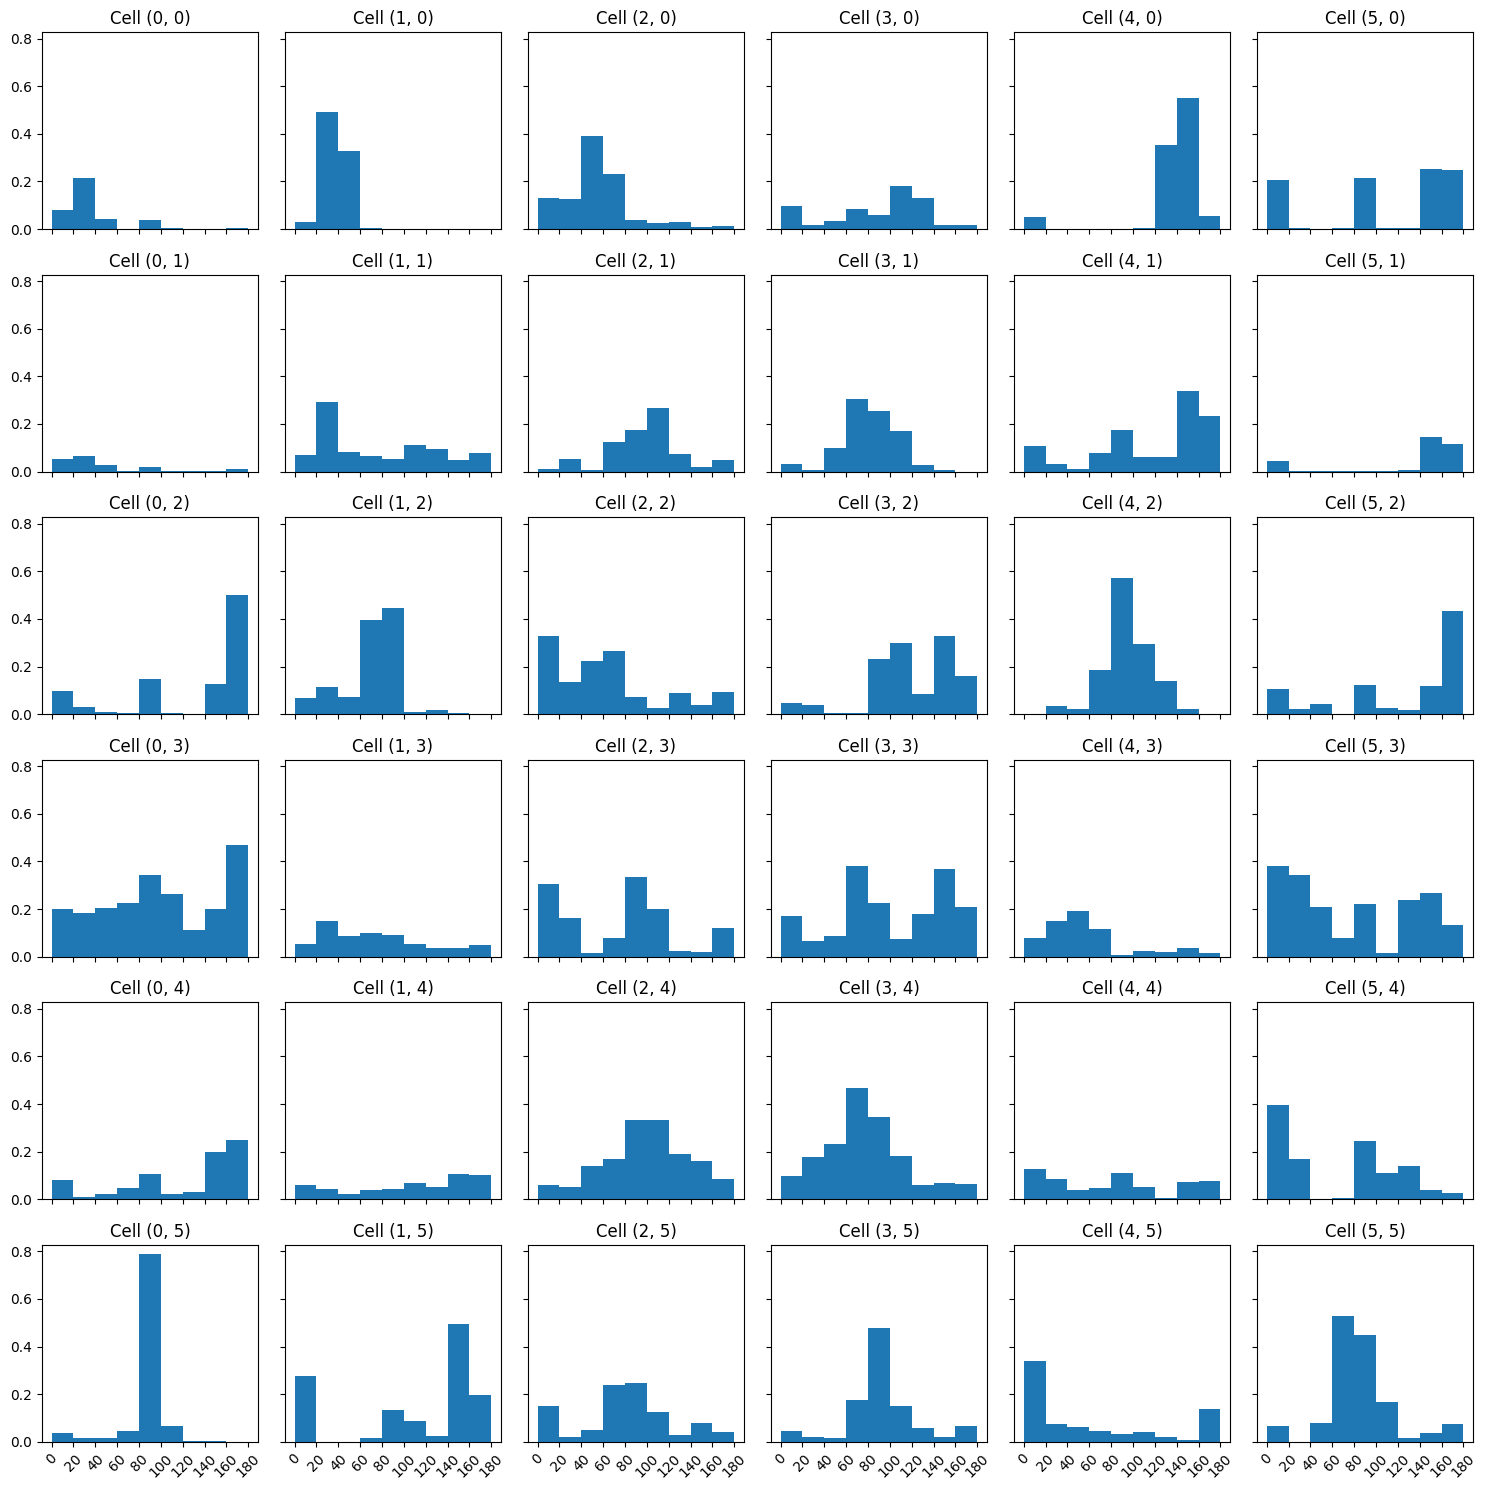

(36, 9)

In [214]:
def block_normalization(histograms, cells_x, cells_y, block_size=(2,2), plot=False):

    blocks_x = cells_y - block_size[0] + 1
    blocks_y = cells_x - block_size[1] + 1

    original_shape = histograms.shape
    histograms = histograms.reshape(cells_x, cells_y, histograms.shape[1])

    normalized_histograms = np.zeros_like(histograms)

    for i in range(blocks_y):
        for j in range(blocks_x):

            block = histograms[i:i+block_size[1], j:j+block_size[0], :]
            block_norm = np.linalg.norm(block)

            if block_norm != 0:
                normalized_block = block / block_norm
            else:
                normalized_block = block

            normalized_histograms[i:i+block_size[1], j:j+block_size[0], :] = normalized_block
    
    normalized_histograms = normalized_histograms.reshape(original_shape)

    if plot:

        histograms = normalized_histograms

        fig, axs = plt.subplots(cells_x,  cells_y, figsize=(15, 15), sharex=True, sharey=True)

        for i in range(cells_y):
            for j in range(cells_x):
                axs[i, j].bar(np.arange(9)*20, histograms[i*cells_y+j], width=20, align='edge')
                axs[i, j].set_title(f'Cell ({j}, {i})')
                axs[i, j].tick_params(axis='x', rotation=45)
        
        plt.xticks(np.arange(0, 10 * 20, 20))
        plt.tight_layout()         
        plt.show()

    return normalized_histograms


normalized_histograms = block_normalization(histograms, cells_x, cells_y, block_size=(2, 2), plot=True)
# normalized_histograms.shape # (36, 9)


### Features

In [122]:
def compute_hog(histograms):

    return histograms.flatten()
    

hog_features = compute_hog(normalized_histograms)
hog_features.shape

(324,)

# Pipelines

### Preprocessing pipeline

In [223]:
def preprocessing_pipeline(data_path, dataset, verbose=False):

    image_files = list(get_image_paths(data_path))

    images = get_images(image_files)
    labels = get_labels(image_files, dataset)

    assert images.shape[0] == labels.shape[0]

    if verbose:
        print(f"Dataset: {dataset}")
        print(f"Dataset length: {len(image_files)}")
        print(f"Image shape: {images[0].shape}")
    
    return images, labels

# images, labels = preprocessing_pipeline(ck_data_path, 'ck')
# images, labels = preprocessing_pipeline(jaffe_data_path, 'jaffe', verbose=True)

### HoG pipeline

In [229]:
def hog_pipeline(
    images, 
    bins = 9,
    cell_size = (8, 8),
    block_size = (2, 2),
    verbose=False
):

    hog_features_images = []

    for image in tqdm(images):

        magnitude, direction = compute_gradients(image)
        histograms, cells_x, cells_y = compute_histograms(magnitude, direction, cell_size, bins)
        normalized_histograms = block_normalization(histograms, cells_x, cells_y, block_size)
        hog_features_image = compute_hog(normalized_histograms)

        hog_features_images.append(hog_features_image)

    hog_features = np.array(hog_features_images)
    
    if verbose:
        print(f"Bins: {bins}")
        print(f"Cell size: {cell_size}")
        print(f"Block size: {block_size}")
        print(f"Histograms: {histograms.shape[0]}")
        print(f"Features: {hog_features.shape[1]}")

    return hog_features

# hog_features = hog_pipeline(images, verbose=True)

### Classification pipeline

In [225]:
def get_score(clf, X, y, train=True):

    pred = clf.predict(X)
    
    metrics = {
        'accuracy': accuracy_score(y, pred),
        'clf_report': classification_report(y, pred),
        'cm': confusion_matrix(y, pred)
    }

    return pred, metrics


def print_score(y_true, y_pred, train=True, add_cr=False, add_cm=False):

    if train:
        print('================================================')
        print("Train Result:")
    else:
        print('================================================')
        print("Test Result:")
    
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy Score: {accuracy * 100:.2f}%")

    if add_cr:
        clf_report = classification_report(y_true, y_pred)
        print("_______________________________________________")
        print(f"Classification report:\n{clf_report}")

    if add_cm:
        cm = confusion_matrix(y_true, y_pred)
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {cm}\n")
    

def classifier_pipeline(features, labels, verbose=False):

    X_train, X_test, y_train, y_test = train_test_split(
        features,
        labels,
        test_size= 0.3,
        random_state=42
    )

    svm_clf = SVC(
        kernel='rbf',
        gamma='scale',
        C= 10 #strength of the regularization is inversely proportional to C
    )
    
    svm_clf.fit(X_train, y_train)

    pred_train, metrics_train = get_score(svm_clf, X_train, y_train, train=True)
    pred_test, metrics_test = get_score(svm_clf, X_test, y_test, train=False)

    if verbose:
        print_score(y_train, pred_train, train=True)
        print_score(y_test, pred_test, train=False)

    return metrics_train, metrics_test

# train_results, test_results = classifier_pipeline(
#     hog_features,
#     labels, 
#     verbose=True
# )

# Final pipeline

In [230]:
def pipeline(
    data_path, 
    dataset,
    bins = 9,
    cell_size = (8, 8),
    block_size = (2, 2),
    test_size = 0.3,
    random_state = 42,
    verbose=False
):
    
    print('--- PREPROCESSING ---')
    images, labels = preprocessing_pipeline(
        data_path=data_path,
        dataset=dataset, 
        verbose=verbose
    ) 

    print('--- HOG ---')
    hog_features = hog_pipeline(
        images=images, 
        bins=bins, 
        cell_size=cell_size, 
        block_size=block_size,
        verbose=verbose
    )
    
    print('--- CLASSIF ---')
    train_results, test_results = classifier_pipeline(
        features=hog_features,
        labels=labels,
        verbose=verbose
    )

    return train_results, test_results

# Evaluation

### CK+48 dataset

In [161]:
train_results, test_results = pipeline(
    ck_data_path, 'ck'
)

--- PREPROCESSING ---


  0%|          | 0/981 [00:00<?, ?it/s]

100%|██████████| 981/981 [00:05<00:00, 165.85it/s]


--- HOG ---


100%|██████████| 981/981 [00:07<00:00, 126.59it/s]


--- CLASSIF ---
Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       Anger       1.00      1.00      1.00        96
     Disgust       1.00      1.00      1.00       112
        Fear       1.00      1.00      1.00        53
   Happiness       1.00      1.00      1.00       138
     Neutral       1.00      1.00      1.00        44
     Sadness       1.00      1.00      1.00        62
    Surprise       1.00      1.00      1.00       181

    accuracy                           1.00       686
   macro avg       1.00      1.00      1.00       686
weighted avg       1.00      1.00      1.00       686

_______________________________________________
Confusion Matrix: 
 [[ 96   0   0   0   0   0   0]
 [  0 112   0   0   0   0   0]
 [  0   0  53   0   0   0   0]
 [  0   0   0 138   0   0   0]
 [  0   0   0   0  44   0   0]
 [  0   0   0   0   0  62   0]
 [  0   0   0   0   0   

### JAFFE dataset

In [286]:
jaffe_data_path = os.path.join(root_path, 'data/JAFFE')

train_results, test_results = pipeline(
    jaffe_data_path, 'jaffe',
    bins = 6, cell_size = (16, 16), block_size = (9, 9),
    verbose=True
)

# --- PREPROCESSING ---
# 100%|██████████| 213/213 [00:00<00:00, 800.95it/s]
# Dataset: jaffe
# Dataset length: 213
# Image shape: (256, 256)
# --- HOG ---
# 100%|██████████| 213/213 [00:11<00:00, 19.24it/s]
# Bins: 9
# Cell size: (18, 18)
# Block size: (9, 9)
# Histograms: 196
# Features: 1764
# --- CLASSIF ---
# ================================================
# Train Result:
# Accuracy Score: 100.00%
# ================================================
# Test Result:
# Accuracy Score: 90.62%





--- PREPROCESSING ---


100%|██████████| 213/213 [00:00<00:00, 1429.68it/s]


Dataset: jaffe
Dataset length: 213
Image shape: (256, 256)
--- HOG ---


100%|██████████| 213/213 [00:04<00:00, 46.45it/s]

Bins: 6
Cell size: (16, 16)
Block size: (9, 9)
Histograms: 256
Features: 1536
--- CLASSIF ---
Train Result:
Accuracy Score: 99.33%
Test Result:
Accuracy Score: 87.50%


##### cell_size exploration

In [277]:
# train_accuracies = []
# test_accuracies = [] 

# for cell_size in range(4, 16):
#     train_results, test_results = pipeline(
#         jaffe_data_path, 'jaffe',
#         bins = 9, cell_size = (cell_size, cell_size), block_size = (3, 3),
#         verbose=True
#     )
#     train_accuracies.append(train_results['accuracy'])
#     test_accuracies.append(test_results['accuracy'])


# fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)

# axs[0].plot(range(4,16), train_accuracies)
# axs[0].set_title(f'Train accuracies')

# axs[1].plot(range(4,16), test_accuracies)
# axs[1].set_title(f'Test accuracies')

# plt.xticks(range(4,16))
# plt.ylim(0, 1)
# plt.tight_layout()         
# plt.savefig('figures/jaffe-cs-search-bins9-bs3x3.png')
# plt.show() 

# # train_accuracies
# # [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# # test_accuracies
# # [0.5625,
# #  0.671875,
# #  0.671875,
# #  0.671875,
# #  0.6875,
# #  0.703125,
# #  0.75,
# #  0.78125,
# #  0.765625,
# #  0.765625,
# #  0.8125, #14
# #  0.796875]

# train_accuracies = []
# test_accuracies = [] 

# for cell_size in range(16, 33):
#     train_results, test_results = pipeline(
#         jaffe_data_path, 'jaffe',
#         bins = 9, cell_size = (cell_size, cell_size), block_size = (3, 3),
#         verbose=True
#     )
#     train_accuracies.append(train_results['accuracy'])
#     test_accuracies.append(test_results['accuracy'])


# fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)

# axs[0].plot(range(16, 33), train_accuracies)
# axs[0].set_title(f'Train accuracies')

# axs[1].plot(range(16, 33), test_accuracies)
# axs[1].set_title(f'Test accuracies')

# plt.xticks(range(16, 33))
# plt.ylim(0, 1)
# plt.tight_layout()         
# plt.savefig('figures/jaffe-cs-search16to32-bins9-bs3x3.png')
# plt.show() 


# train_accuracies
# [1.0, #16
#  1.0,
#  1.0,
#  1.0,
#  1.0,
#  1.0, # 21
#  1.0,
#  1.0,
#  1.0,
#  0.9932885906040269,
#  1.0,
#  1.0, #27
#  1.0,
#  0.9932885906040269, #29
#  1.0,
#  1.0, #31
#  0.9932885906040269] #32

# test_accuracies 
# [0.796875, #16
#  0.765625,
#  0.859375,
#  0.828125,
#  0.828125,
#  0.875, #21
#  0.859375,
#  0.859375,
#  0.84375,
#  0.84375,
#  0.859375,
#  0.875, #27
#  0.859375,
#  0.875, #29
#  0.859375,
#  0.875, # 31
#  0.84375] #32

##### block_size exploration

In [278]:
# train_accuracies = []
# test_accuracies = [] 

# for block_size in range(1, 16):
#     train_results, test_results = pipeline(
#         jaffe_data_path, 'jaffe',
#         bins = 9, cell_size = (16, 16), block_size = (block_size, block_size),
#         verbose=True
#     )
#     train_accuracies.append(train_results['accuracy'])
#     test_accuracies.append(test_results['accuracy'])


# fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)

# axs[0].plot(range(1, 16), train_accuracies)
# axs[0].set_title(f'Train accuracies')

# axs[1].plot(range(1, 16), test_accuracies)
# axs[1].set_title(f'Test accuracies')

# plt.xticks(range(1, 16))
# plt.ylim(0, 1)
# plt.tight_layout()         
# plt.savefig('figures/jaffe-bs-search-bins9-cs16x16.png')
# plt.show() 

# train_accuracies
# [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# test_accuracies
# [0.765625, # 1
#  0.78125,
#  0.796875,
#  0.8125,
#  0.828125,
#  0.859375,
#  0.859375,
#  0.859375,
#  0.875, #9
#  0.859375,
#  0.859375,
#  0.859375,
#  0.859375,
#  0.859375,
#  0.859375] #15

##### bins exploration

In [246]:
# train_accuracies = []
# test_accuracies = [] 

# for bins in range(1, 19):
#     train_results, test_results = pipeline(
#         jaffe_data_path, 'jaffe',
#         bins = bins, cell_size = (16, 16), block_size = (8, 8),
#         verbose=False
#     )
#     train_accuracies.append(train_results['accuracy'])
#     test_accuracies.append(test_results['accuracy'])

# fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)

# axs[0].plot(range(1, 19), train_accuracies)
# axs[0].set_title(f'Train accuracies')

# axs[1].plot(range(1, 19), test_accuracies)
# axs[1].set_title(f'Test accuracies')

# plt.xticks(range(1, 19))
# plt.ylim(0, 1)
# plt.tight_layout()         
# plt.savefig('figures/jaffe-bins-search-cs16x16-bs8x8.png')
# plt.show()    

# train_accuracies
# [0.9932885906040269,
#  0.9932885906040269,
#  0.9932885906040269,
#  0.9932885906040269,
#  0.9932885906040269,
#  0.9932885906040269,
#  1.0,
#  1.0,
#  1.0,
#  1.0,
#  1.0,
#  1.0,
#  1.0,
#  1.0,
#  1.0,
#  1.0,
#  1.0,
#  1.0]

# test_accuracies
# [0.828125,
#  0.828125,
#  0.859375,
#  0.828125,
#  0.859375,
#  0.859375,
#  0.84375,
#  0.859375,
#  0.859375,
#  0.859375,
#  0.859375,
#  0.859375,
#  0.859375,
#  0.859375,
#  0.859375,
#  0.859375,
#  0.859375,
#  0.859375]

##### GridSearch

In [ ]:
from skimage import feature
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

images, labels = preprocessing_pipeline(
    jaffe_data_path,
    'jaffe'
)

X_train, X_test, y_train, y_test = train_test_split(
    images,
    labels,
    test_size=0.3,
    random_state=42
)

In [ ]:
class HOGTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        hog_features = [feature.hog(image, orientations=self.orientations,
                                    pixels_per_cell=self.pixels_per_cell,
                                    cells_per_block=self.cells_per_block)
                        for image in X]
        return np.array(hog_features)

sk_pipeline = Pipeline([
    ('hog_features', HOGTransformer()),
    ('svc', SVC(kernel='rbf', gamma='scale', C= 10))
])

In [285]:
param_grid = {
    'hog_features__orientations': [6, 9, 10, 12, 18],
    'hog_features__pixels_per_cell': [(8,8), (12,12), (16,16), (18,18), (21,21)],
    'hog_features__cells_per_block': [(2,2), (3,3), (6,6), (9,9), (12,12), (16,16)]

}

grid_search = GridSearchCV(
    estimator=sk_pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=4,
    verbose=3
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print("Best parameters found by grid search:")
print(best_params)


y_train_pred = best_estimator.predict(X_train)
print("\nTest Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(y_train, y_train_pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{classification_report(y_train, y_train_pred)}")
print("_______________________________________________")
print(f"Confusion Matrix: \n{confusion_matrix(y_train, y_train_pred)}")


y_test_pred = best_estimator.predict(X_test)
print("\nTest Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(y_test, y_test_pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{classification_report(y_test, y_test_pred)}")
print("_______________________________________________")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_test_pred)}")


# Best parameters found by grid search:
# {'hog_features__cells_per_block': (9, 9), 'hog_features__orientations': 6, 'hog_features__pixels_per_cell': (16, 16)}

# Test Result:
# ================================================
# Accuracy Score: 99.33%
# _______________________________________________
# CLASSIFICATION REPORT:
#               precision    recall  f1-score   support

#        Anger       1.00      1.00      1.00        20
#      Disgust       1.00      1.00      1.00        23
#         Fear       1.00      1.00      1.00        20
#    Happiness       0.95      1.00      0.98        21
#      Neutral       1.00      1.00      1.00        21
#      Sadness       1.00      0.96      0.98        23
#     Surprise       1.00      1.00      1.00        21

#     accuracy                           0.99       149
#    macro avg       0.99      0.99      0.99       149
# weighted avg       0.99      0.99      0.99       149

# _______________________________________________
# Confusion Matrix: 
# [[20  0  0  0  0  0  0]
#  [ 0 23  0  0  0  0  0]
#  [ 0  0 20  0  0  0  0]
#  [ 0  0  0 21  0  0  0]
#  [ 0  0  0  0 21  0  0]
#  [ 0  0  0  1  0 22  0]
#  [ 0  0  0  0  0  0 21]]

# Test Result:
# ================================================
# Accuracy Score: 85.94%
# _______________________________________________
# CLASSIFICATION REPORT:
#               precision    recall  f1-score   support

#        Anger       0.88      0.70      0.78        10
#      Disgust       0.56      0.83      0.67         6
#         Fear       1.00      0.58      0.74        12
#    Happiness       1.00      1.00      1.00        10
#      Neutral       1.00      1.00      1.00         9
#      Sadness       0.73      1.00      0.84         8
#     Surprise       0.90      1.00      0.95         9

#     accuracy                           0.86        64
#    macro avg       0.87      0.87      0.85        64
# weighted avg       0.89      0.86      0.86        64

# _______________________________________________
# Confusion Matrix: 
# [[ 7  3  0  0  0  0  0]
#  [ 1  5  0  0  0  0  0]
#  [ 0  1  7  0  0  3  1]
#  [ 0  0  0 10  0  0  0]
#  [ 0  0  0  0  9  0  0]
#  [ 0  0  0  0  0  8  0]
#  [ 0  0  0  0  0  0  9]]

 41%|████▏     | 88/213 [00:00<00:00, 405.87it/s]

100%|██████████| 213/213 [00:00<00:00, 370.58it/s]


Fitting 4 folds for each of 150 candidates, totalling 600 fits
[CV 1/4] END hog_features__cells_per_block=(2, 2), hog_features__orientations=6, hog_features__pixels_per_cell=(8, 8);, score=0.605 total time=  13.7s
[CV 2/4] END hog_features__cells_per_block=(2, 2), hog_features__orientations=6, hog_features__pixels_per_cell=(8, 8);, score=0.568 total time=  11.3s
[CV 3/4] END hog_features__cells_per_block=(2, 2), hog_features__orientations=6, hog_features__pixels_per_cell=(8, 8);, score=0.541 total time=  10.6s
[CV 4/4] END hog_features__cells_per_block=(2, 2), hog_features__orientations=6, hog_features__pixels_per_cell=(8, 8);, score=0.838 total time=  11.4s
[CV 1/4] END hog_features__cells_per_block=(2, 2), hog_features__orientations=6, hog_features__pixels_per_cell=(12, 12);, score=0.632 total time=   4.6s
[CV 2/4] END hog_features__cells_per_block=(2, 2), hog_features__orientations=6, hog_features__pixels_per_cell=(12, 12);, score=0.622 total time=   4.8s
[CV 3/4] END hog_features__

c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
40 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\alexa\AppDa

Best parameters found by grid search:
{'hog_features__cells_per_block': (9, 9), 'hog_features__orientations': 6, 'hog_features__pixels_per_cell': (16, 16)}

Test Result:
Accuracy Score: 99.33%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       Anger       1.00      1.00      1.00        20
     Disgust       1.00      1.00      1.00        23
        Fear       1.00      1.00      1.00        20
   Happiness       0.95      1.00      0.98        21
     Neutral       1.00      1.00      1.00        21
     Sadness       1.00      0.96      0.98        23
    Surprise       1.00      1.00      1.00        21

    accuracy                           0.99       149
   macro avg       0.99      0.99      0.99       149
weighted avg       0.99      0.99      0.99       149

_______________________________________________
Confusion Matrix: 
[[20  0  0  0  0  0  0]
 [ 0 23  0  0  0  0  0]
 [ 0  0 20  0  0  0  0]
